In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.data import AUTOTUNE
import sentiment


DATASET_DIR = './goemotions/data-v2/'

In [2]:
classes = sentiment.load_classes(DATASET_DIR)
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

D:\sentiment-analysis\sentiment.py:392: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


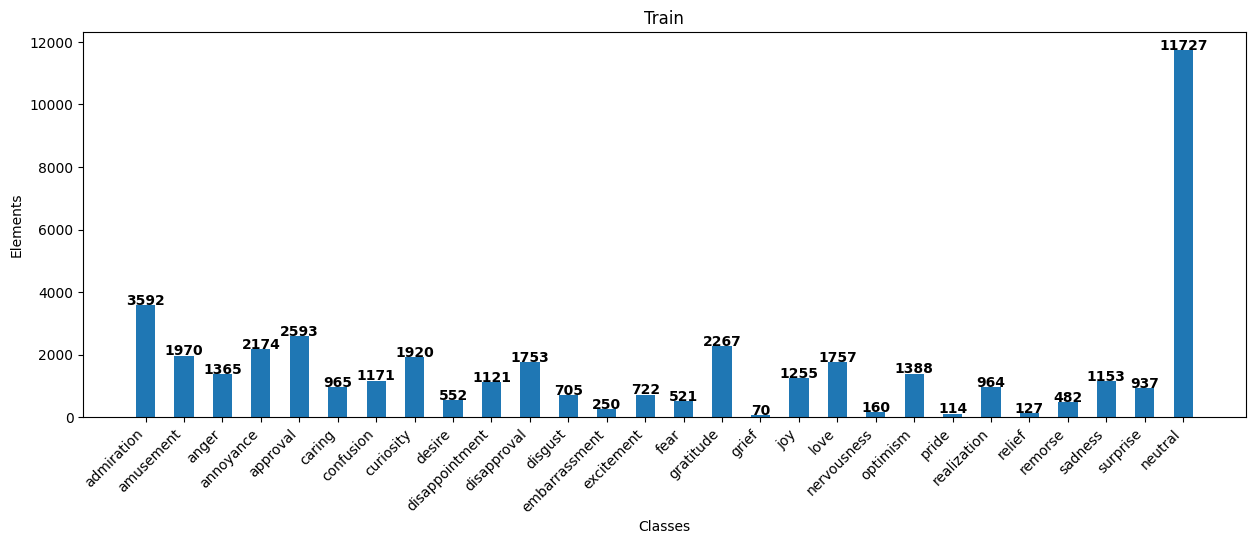

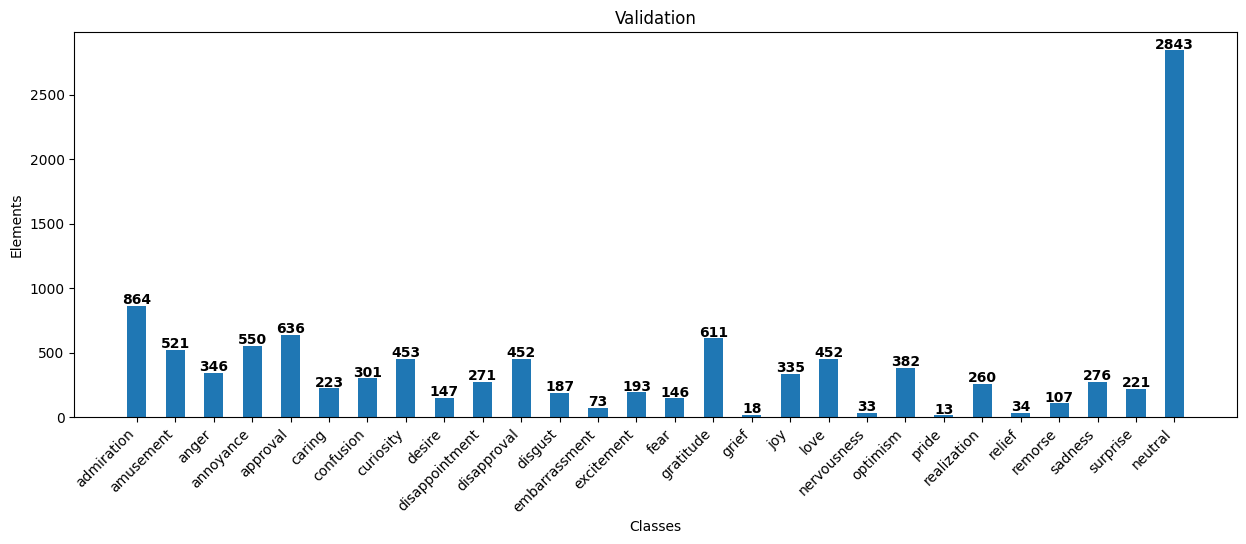

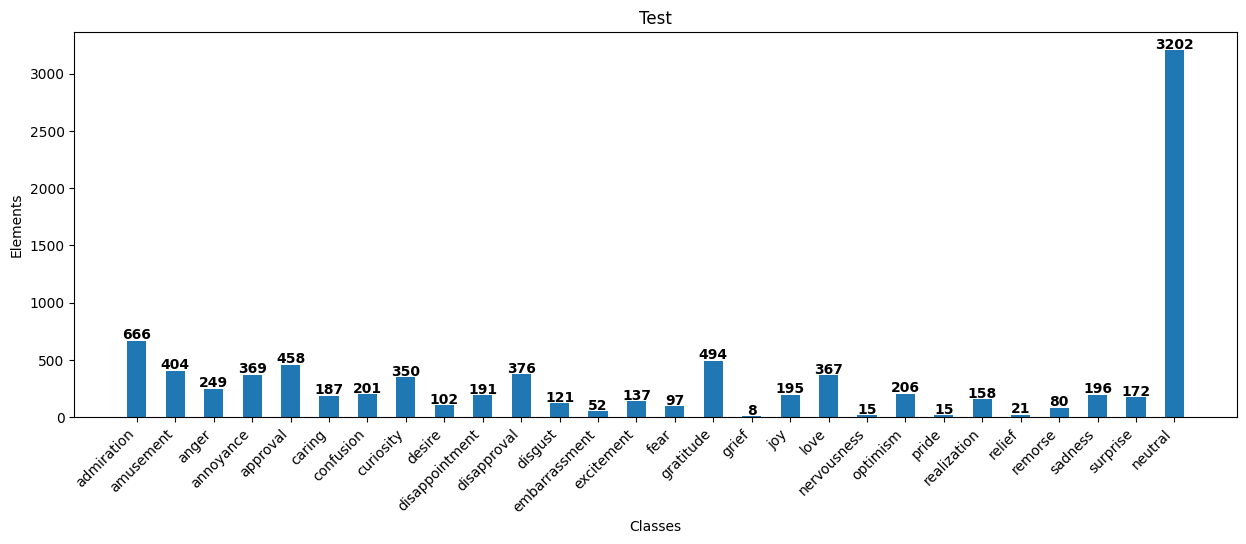

CPU times: total: 8.55 s
Wall time: 9.16 s


In [3]:
%%time
BATCH_SIZE = 64


train_df, val_df, test_df = sentiment.make_dataframes(DATASET_DIR,
                                                      fraction=0.8,
                                                      clean=True,
                                                      cut_neutral=False,
                                                      optimize_low=False)
dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    sentiment.plot_class_distr(df, classes, title)
train_ds = sentiment.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = sentiment.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = sentiment.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

In [4]:
from tensorflow.keras.layers import TextVectorization

VOCAB_SIZE = 20_000


encoder = TextVectorization(max_tokens=VOCAB_SIZE,
                            standardize='lower_and_strip_punctuation',
                            split='whitespace',
                            pad_to_max_tokens=True,
                            ngrams=(1, 2),
                            output_mode='tf_idf')
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['[UNK]', 'i', 'the', 'is', 'to', 'a', 'you', 'it', 'that', 'and',
       'not', 'of', 'this', 'in', 'for', 'are', 'have', 'was', 'do', 'my'],
      dtype='<U20')

In [5]:
from tensorflow.keras.layers import (Dropout, Dense)
from tensorflow.keras import Sequential

classifier = Sequential([
    encoder,
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(classes), activation='sigmoid'),
])

In [6]:
from tensorflow.keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

METRICS_THRESHOLD = 0.5
LEARNING_RATE = 2e-5


metrics = sentiment.create_metrics(classes, METRICS_THRESHOLD)
loss = BinaryCrossentropy()
classifier.compile(Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=metrics)

In [7]:
class_counts = sentiment.get_class_counts(train_df)
total = sum(class_counts)
class_weights = {i: total / count for i, count in enumerate(class_counts)}
class_weights

{0: 12.186804008908686,
 1: 22.220812182741117,
 2: 32.06959706959707,
 3: 20.135694572217112,
 4: 16.88198997300424,
 5: 45.362694300518136,
 6: 37.38257899231426,
 7: 22.799479166666668,
 8: 79.30253623188406,
 9: 39.04995539696699,
 10: 24.971477467199087,
 11: 62.09219858156028,
 12: 175.1,
 13: 60.63019390581717,
 14: 84.021113243762,
 15: 19.309660344067048,
 16: 625.3571428571429,
 17: 34.8804780876494,
 18: 24.91462720546386,
 19: 273.59375,
 20: 31.538184438040346,
 21: 383.99122807017545,
 22: 45.4097510373444,
 23: 344.68503937007875,
 24: 90.8195020746888,
 25: 37.9661751951431,
 26: 46.71824973319104,
 27: 3.7328387481879424}

In [8]:
from tensorflow.keras.callbacks import EarlyStopping


EPOCHS = 100


hist = classifier.fit(x=train_ds, validation_data=val_ds,
                      validation_steps=30, epochs=EPOCHS,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                      # class_weight=class_weights
                     )

Epoch 1/100
565/565 [==============================] - 36s 53ms/step - loss: 0.5206 - precision@0.5/admiration: 0.1042 - recall@0.5/admiration: 0.6506 - precision@0.5/amusement: 0.0448 - recall@0.5/amusement: 0.0619 - precision@0.5/anger: 0.0401 - recall@0.5/anger: 0.2886 - precision@0.5/annoyance: 0.0608 - recall@0.5/annoyance: 0.1679 - precision@0.5/approval: 0.0740 - recall@0.5/approval: 0.0868 - precision@0.5/caring: 0.0284 - recall@0.5/caring: 0.1606 - precision@0.5/confusion: 0.0313 - recall@0.5/confusion: 0.0504 - precision@0.5/curiosity: 0.0558 - recall@0.5/curiosity: 0.3786 - precision@0.5/desire: 0.0141 - recall@0.5/desire: 0.4982 - precision@0.5/disappointment: 0.0301 - recall@0.5/disappointment: 0.0134 - precision@0.5/disapproval: 0.0556 - recall@0.5/disapproval: 0.0456 - precision@0.5/disgust: 0.0193 - recall@0.5/disgust: 0.0723 - precision@0.5/embarrassment: 0.0041 - recall@0.5/embarrassment: 0.0240 - precision@0.5/excitement: 0.0250 - recall@0.5/excitement: 0.0374 - prec

In [9]:
eval_metrics = classifier.evaluate(x=test_ds, return_dict=True)
sentiment.print_metrics(eval_metrics)

143/143 [==============================] - 2s 16ms/step - loss: 0.0900 - precision@0.5/admiration: 0.7472 - recall@0.5/admiration: 0.4925 - precision@0.5/amusement: 0.7649 - recall@0.5/amusement: 0.5396 - precision@0.5/anger: 0.6104 - recall@0.5/anger: 0.1888 - precision@0.5/annoyance: 0.2439 - recall@0.5/annoyance: 0.0542 - precision@0.5/approval: 0.4000 - recall@0.5/approval: 0.1004 - precision@0.5/caring: 0.5278 - recall@0.5/caring: 0.1016 - precision@0.5/confusion: 0.6364 - recall@0.5/confusion: 0.1393 - precision@0.5/curiosity: 0.5000 - recall@0.5/curiosity: 0.2057 - precision@0.5/desire: 0.6122 - recall@0.5/desire: 0.2941 - precision@0.5/disappointment: 0.5333 - recall@0.5/disappointment: 0.0419 - precision@0.5/disapproval: 0.3784 - recall@0.5/disapproval: 0.0745 - precision@0.5/disgust: 0.8182 - recall@0.5/disgust: 0.2231 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/excitement: 0.6000 - recall@0.5/excitement: 0.1533 - precision

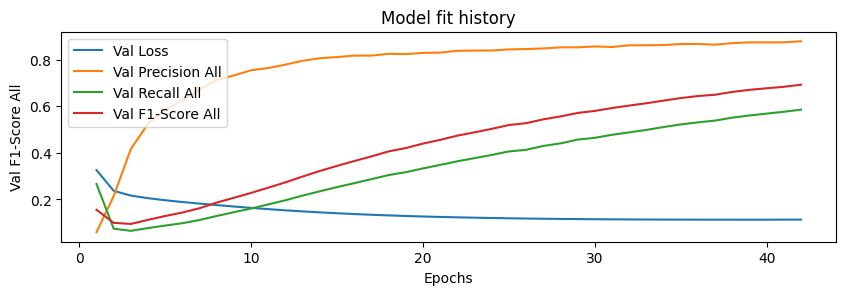

In [10]:
stats = hist.history
stats_graps = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['precision@0.5/all'],
    'Val Recall All': stats['recall@0.5/all'],
    'Val F1-Score All': stats['f1_score@0.5/all']
}
sentiment.plot_history(stats_graps)

In [11]:
sentiment.calc_accuracy(test_ds, classifier)

0.54890525

In [12]:
sentiment.test_examples(classifier, classes)

I am feeling great today!: admiration 👏
The weather is so good: admiration 👏
I have performed well at the university: neutral ⚪
The war has started: neutral ⚪
He is desperate in this cruel world: neutral ⚪
I love the feeling when my girlfriend hugs me: love ❤️
I hate monday mornings: anger 😡
Look forward to seeing you today: neutral ⚪
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : joy 😃
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find time to read :) Aaaaand you can actually choose sth new): gratitude 🙏
I have the new pan for pancakes.: neutral ⚪
I'm wearing a special red ribbon for luck.: anger 😡
OMG, yep!!! That is the final answer! Thank you so much!: gratitude 🙏
I am so glad this is over: joy 😃
Sorry, I feel bad for having said that: sadness 😞
Happy birthday, my friend! I wish you a lot of success!: desire 😍
What a shame! I will never talk to him: embarrassment 😳
What if she

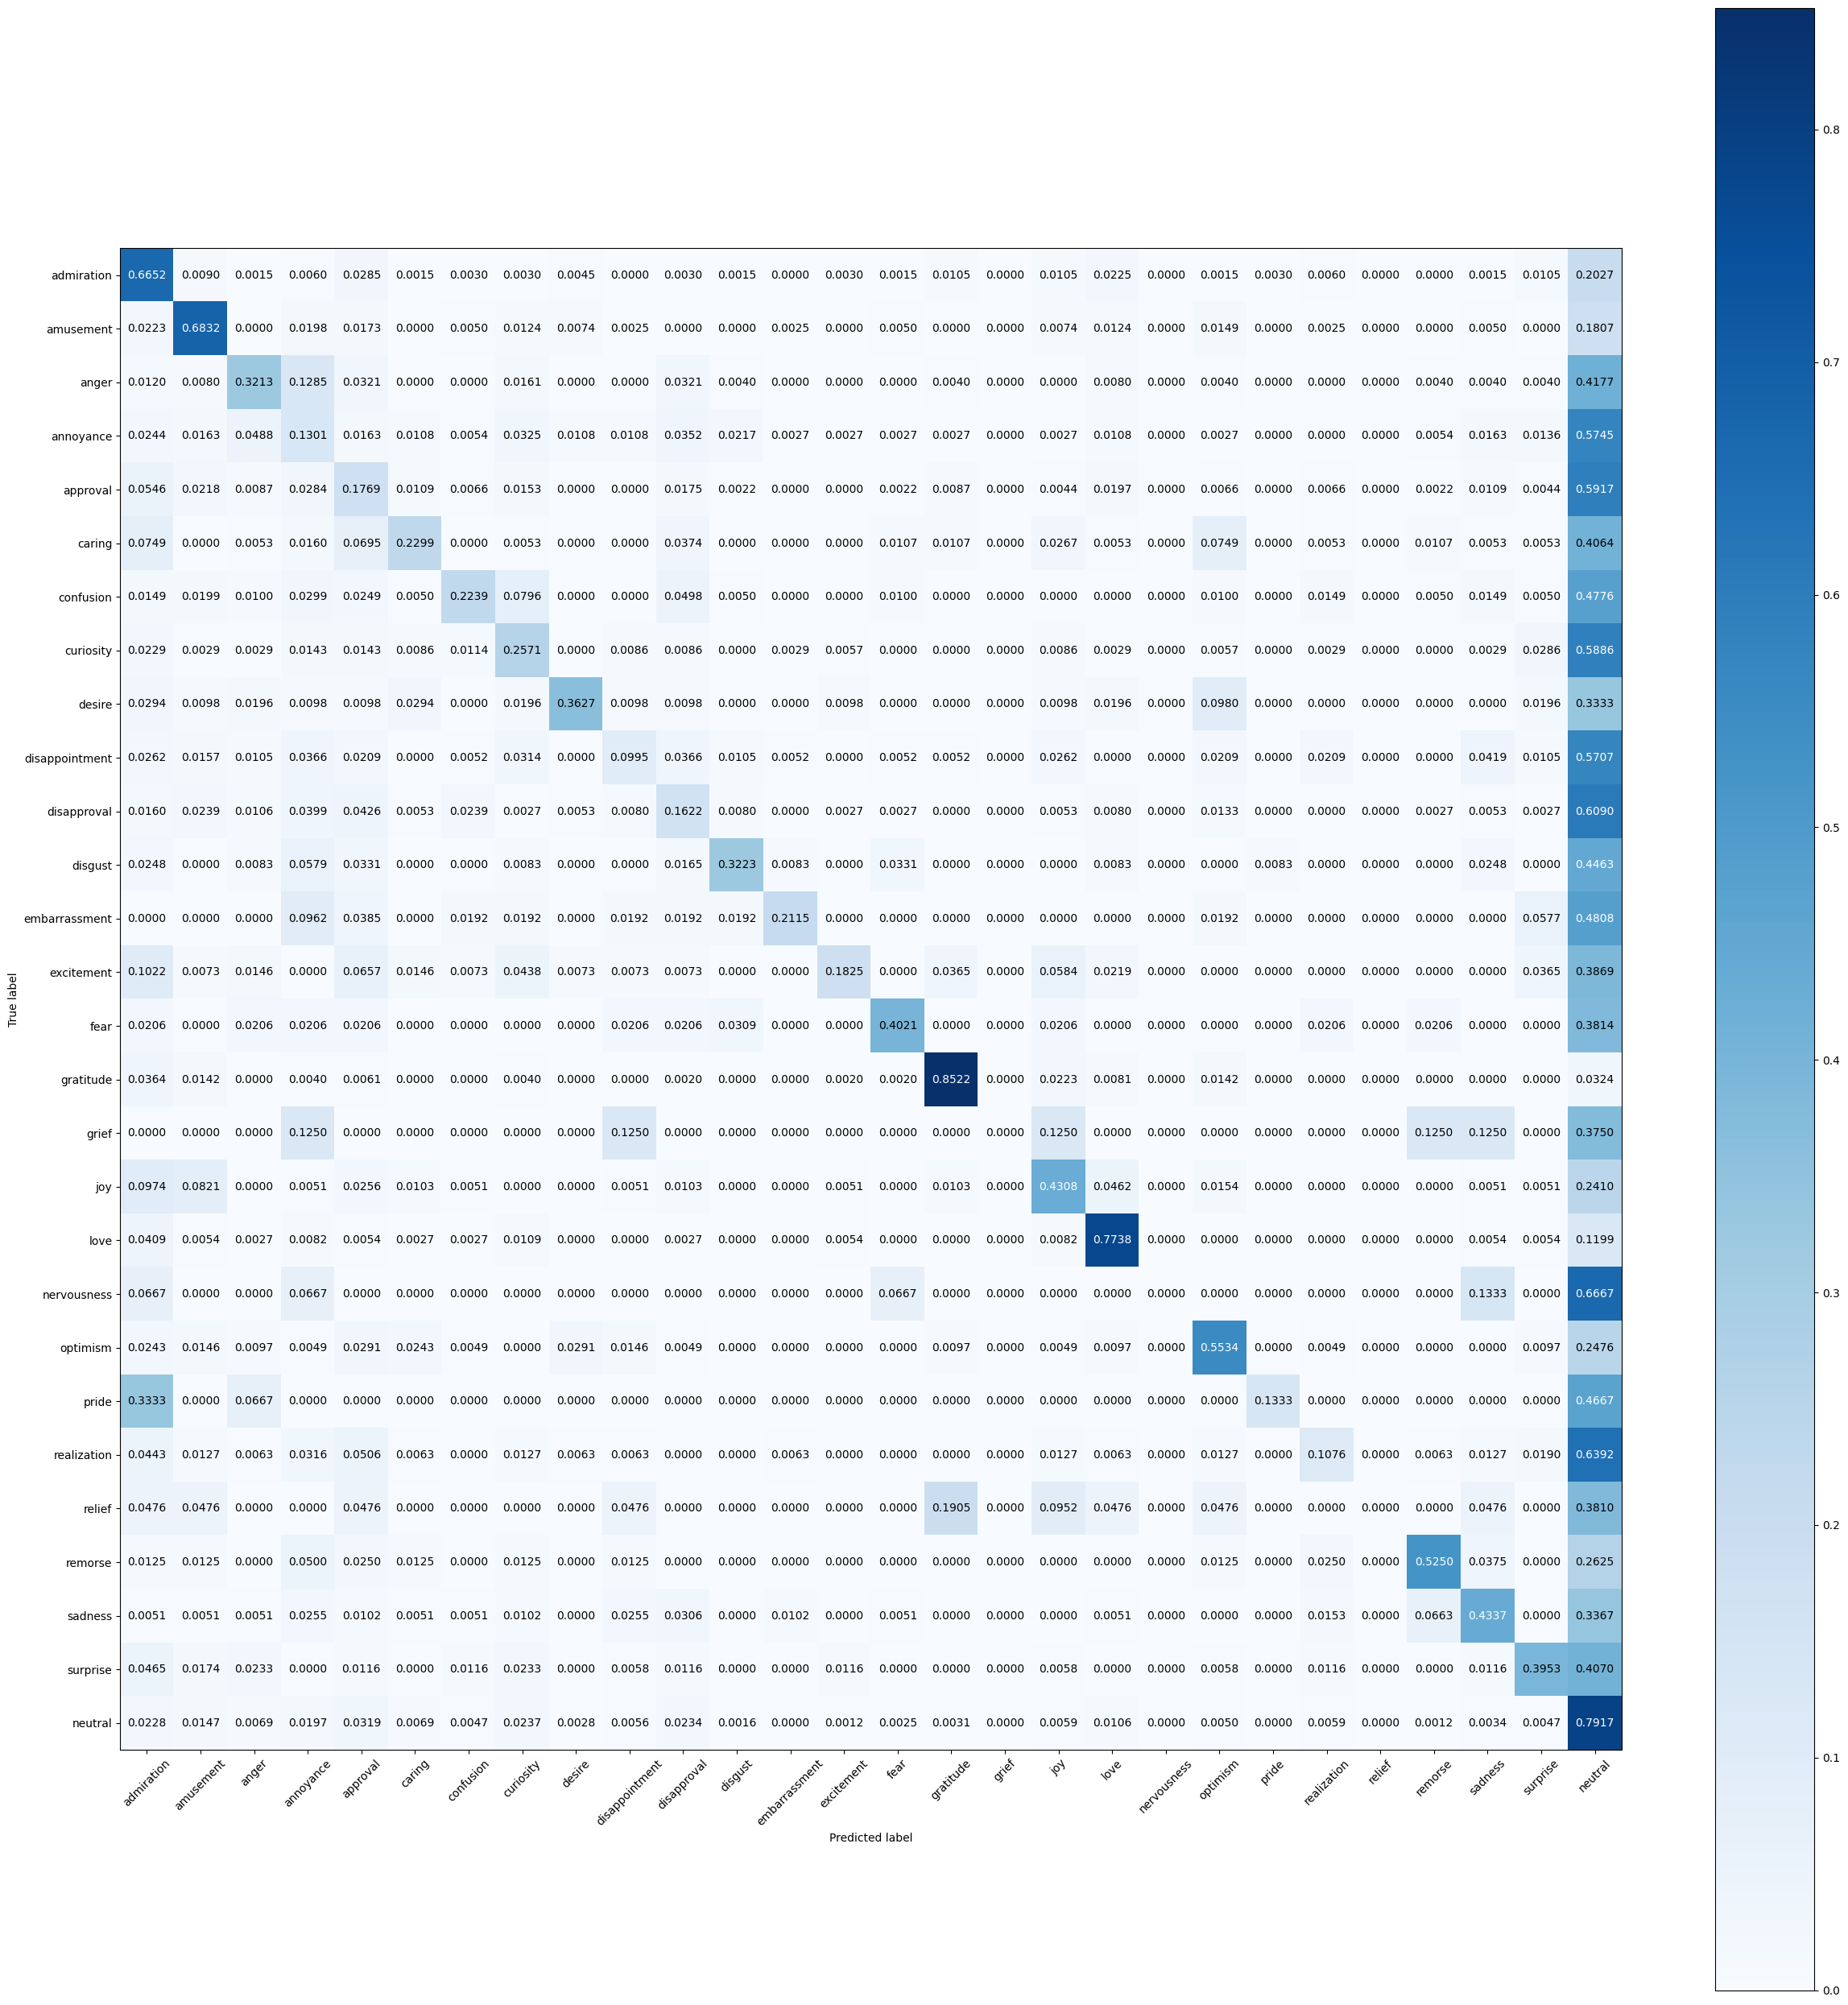

In [13]:
sentiment.plot_conf_mtrx_all(classifier, test_ds, classes)

1/1 [==============================] - 0s 146ms/step


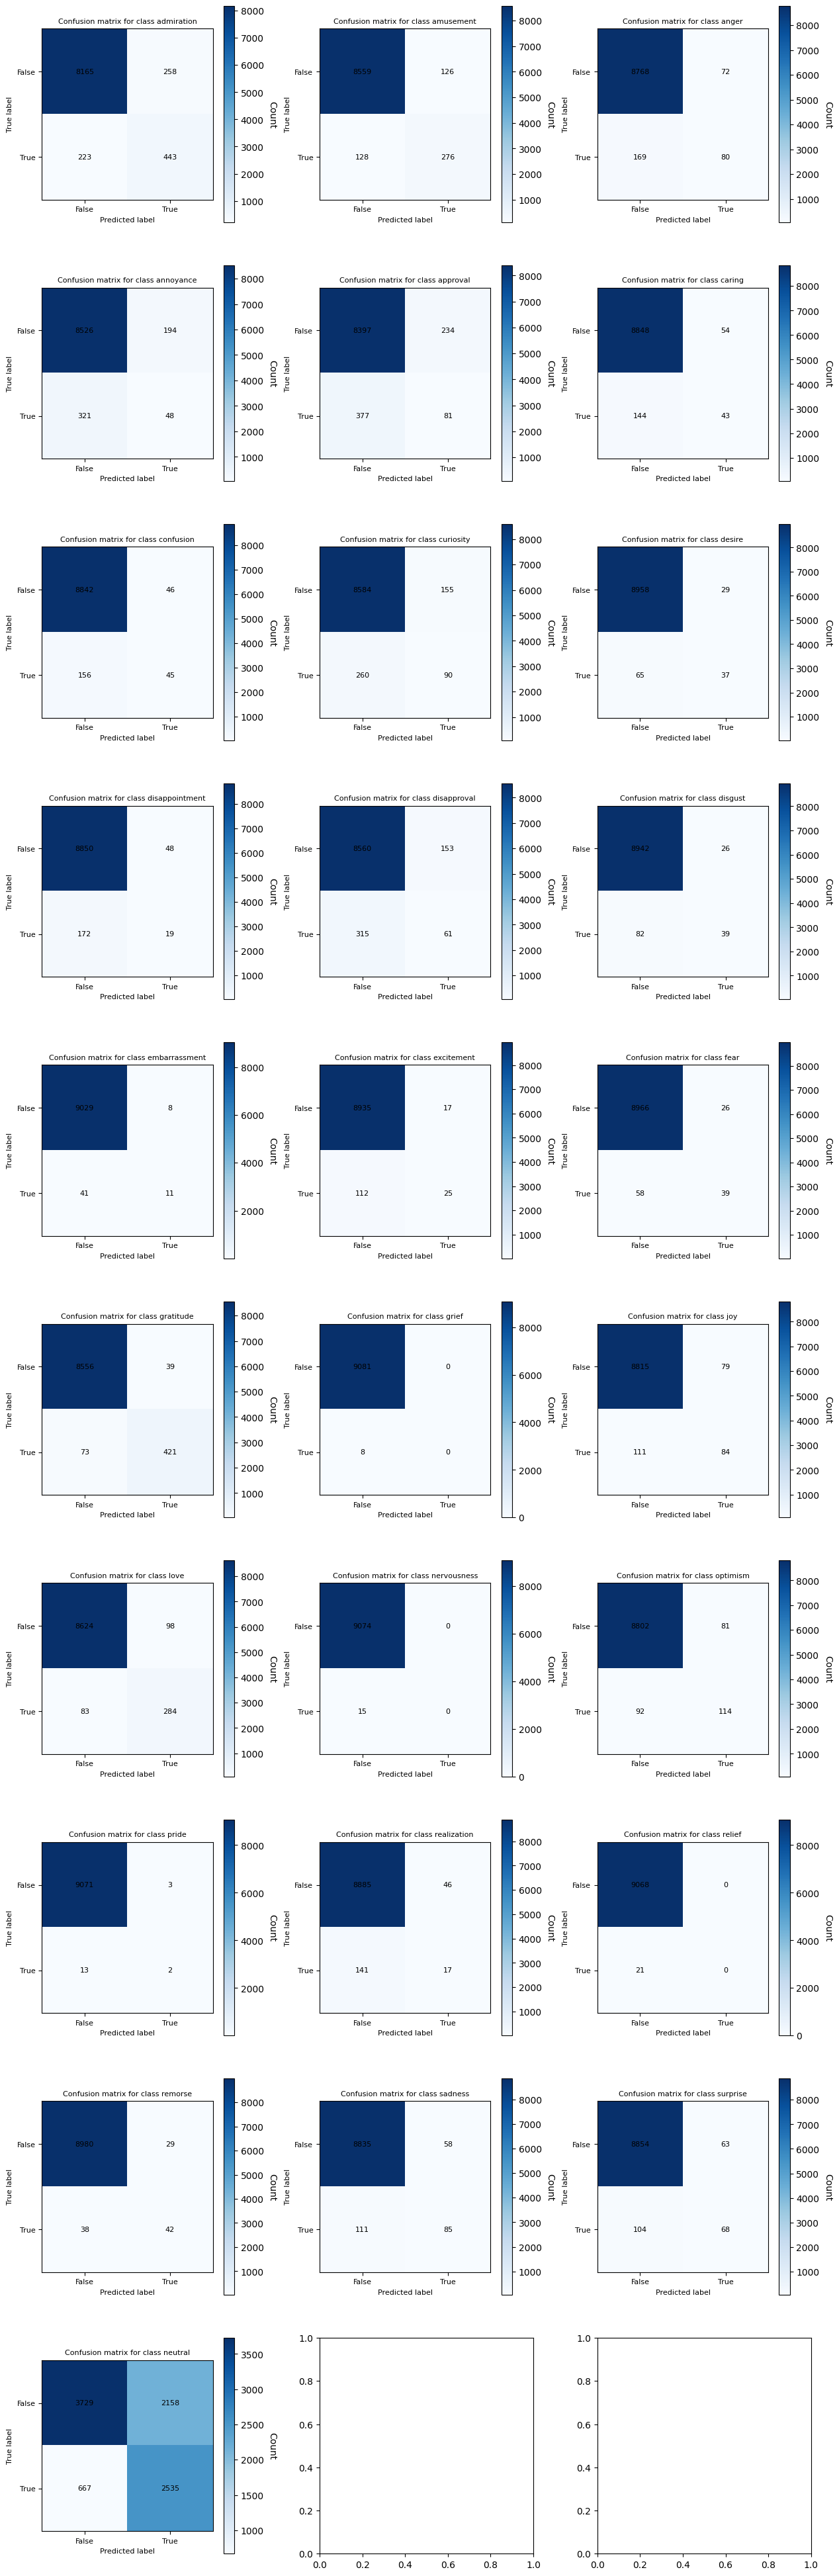

In [14]:
sentiment.plot_conf_mtrx_per_class(classifier, test_ds, classes, rounded=False)

In [15]:
classifier.save('./models/mlp', include_optimizer=False)

INFO:tensorflow:Assets written to: ./models/mlp\assets


## Notes 
### Experiment 1
__Encoder:__ 20000, tf_df, ngram=2  
__Dataset:__ BATCH_SIZE=128 fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=1e-4, eary stop at 2  
__Result:__
F1Score all: `0.31189`  
Accuracy: `0.4528551`  
Grief and relief have zero metrics  
  
### Experiment 2
__Encoder:__ 20000, tf_df, ngram=2  
__Dataset:__ BATCH_SIZE = 128 fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2, ___added BatchNormalization layer before activation layer___  
__Learning:__ LR=1e-4, eary stop at 2  
__Result:__
F1Score all: `0.29137`  
Accuracy: `0.4734294`  
Grief and nervousness have zero metrics 

### Experiment 3
__Encoder:__ 20000, tf_df, ngram=2  
__Dataset:__ BATCH_SIZE = 64 fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=1e-4, eary stop at 2  
__Result:__
F1Score all: `0.2987`  
Accuracy: `0.46627793`  
__All classes have non-zero metrics__

### Experiment 4
__Encoder:__ 20000, tf_df, ngram=2  
__Dataset:__ BATCH_SIZE = 64 fraction=0.8, cut_neutral=True, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=1e-4, early stop at 2  
__Result:__
F1Score all: `0.3905`  
Accuracy: `0.48134044`  
Grief and relief have zero metrics

### Experiment 5
__Encoder:__ 20000, tf_df, ngram=2  
__Dataset:__ BATCH_SIZE = 32 fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=1e-4, early stop at 2  
__Result:__
F1Score all: `0.3167`  
Accuracy: `0.47496974`  
Grief has zero metrics 

### Experiment 6
__Encoder:__ 20000, tf_df, ngram=2  
__Dataset:__ BATCH_SIZE = 64 fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=1e-4, early stop at 3  
__Result:__
F1Score all: `0.33037`  
Accuracy: `0.44658378`  
Grief has zero metrics 

### Experiment 7
__Encoder:__ 20000, tf_df, ngram=2  
__Dataset:__ BATCH_SIZE = 64 fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=1e-4, early stop at 5  
__Result:__
F1Score all: `0.3370`  
Accuracy: `0.44746396`  
__All classes have non-zero metrics__  

### Experiment 8
__Encoder:__ 20000, tf_df, ngram=2  
__Dataset:__ BATCH_SIZE = 64 fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=1e-4, early stop at 10  
__Result:__
F1Score all: `0.35816`  
Accuracy: `0.45252502`  
Relief has zero metrics   

### Experiment 8
__Encoder:__ 20000, tf_df, ngram=2  
__Dataset:__ BATCH_SIZE = 64 fraction=0.8, cut_neutral=False, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=1e-4, no early stop, 50 epochs  
__Result:__
F1Score all: `0.38314`  
Accuracy: `0.43206072`  
Relief has zero metrics    

### Experiment 9 - WITH CLEANING
__Encoder:__ 20000, tf_df, ngram=(1, 2)  
__Dataset:__ BATCH_SIZE = 64 fraction=0.8, cut_neutral=True, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=1e-4, early stop at 3, 100 epochs, no class weights    
__Result:__
F1Score all: `0.41347`  
Accuracy: `0.4923077`  
Grief, pride, relief has zero metrics    


### Experiment 10 - WITH CLEANING
__Encoder:__ 20000, tf_df, ngram=(1, 2)  
__Dataset:__ BATCH_SIZE = 64 fraction=0.8, cut_neutral=True, optimize_low=False  
__Arch:__ 1 Dense layer with 128 units, dropout=0.2  
__Learning:__ LR=3e-5, early stop at 3, 100 epochs, no class weights    
__Result:__
F1Score all: `0.42953`  
Accuracy: `0.54890525`  
embarrassment, grief, nervousness, relief have zero metrics    


---
_Using both optimize_low and class_weights all metrics have non-zero value, but total result is lower. accuracy is still not high enough.  
Try with maxsequence  
Try with Learning Rate exponential decay  
F1-Score weights?_